# Approach based on density maps generation

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
#from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
# Torchvision library
import torchvision
import torch.nn as nn
from tqdm import tqdm # plot progress bars
import numpy as np

import os
import pandas as pd
#from torchvision.io import read_image
from PIL import Image
import seaborn as sns
import torch.utils.data as data
import copy
import cv2

C:\Users\hilar\anaconda3\envs\NNDL_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data adquisition  definition of the Dataset class and Dataloader

In [3]:
class CustomImageDataset(Dataset):

    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir    = img_dir
        self.transform  = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = Image.open(img_path) # I load it as a PIL image so I can perform some transforms that are not available for tensors.
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 2])
        label    = cv2.imread(label_path,flags=cv2.IMREAD_ANYDEPTH)
        label *= 1e3
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    

In [4]:
path = "C:/Users/hilar/Documents/Data/GitHub/Vision_Cognitive_Systems_Proyect/Corn/corn_kenel_counting_dataset/corn_kenel_counting_dataset/"

dataset = "corn"

train_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_train_labels.csv" 
train_data_path = path + f"{dataset}_coco/train_set" 

test_csv_path  = path + f"{dataset}_coco/{dataset}_kernel_test_labels.csv" 
test_data_path = path + f"{dataset}_coco/test_set"


In [5]:
### Define transforms
train_transforms = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((224,224)),])

# The test dataset must remain as original as possible
test_transforms = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224,224)),])

target_transform = transforms.Compose([transforms.ToTensor(),
                                      transforms.Resize((224,224)),]) 

In [6]:
### Define dataset
train_dataset = CustomImageDataset(train_csv_path, train_data_path,
                                   transform=train_transforms,
                                   target_transform = target_transform)

test_dataset = CustomImageDataset(test_csv_path, test_data_path,
                                  transform = test_transforms,
                                  target_transform = target_transform)

In [7]:
# Split train data into train and validation sets
# (10% of training set will be used as validation set)
num_train_examples = int(len(train_dataset) * 0.90)
num_valid_examples = len(train_dataset) - num_train_examples

print(f"Number of training examples: {num_train_examples}")

Number of training examples: 217


In [8]:
# Create 'Subset' objects
train_dataset, validation_dataset = data.random_split(train_dataset, [num_train_examples, num_valid_examples])

print(f"Number training examples: {len(train_dataset)}")
print(f"Number validation examples: {len(validation_dataset)}")
print(f"Number test examples: {len(test_dataset)}")

Number training examples: 217
Number validation examples: 25
Number test examples: 62


In [9]:
# Apply test transformations to the validation set
validation_dataset = copy.deepcopy(validation_dataset) # If we change train transformations, this won't affect the validation set
validation_dataset.dataset.transform = test_transforms

In [10]:
# data Loaders
train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True, num_workers=0)
validation_dataloader = DataLoader(validation_dataset, batch_size=len(validation_dataset), shuffle=False, num_workers=0)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False, num_workers=0)


Lets check if dataloaders are working properly

Feature batch shape: torch.Size([50, 3, 224, 224])
Labels batch shape: torch.Size([50, 1, 224, 224])


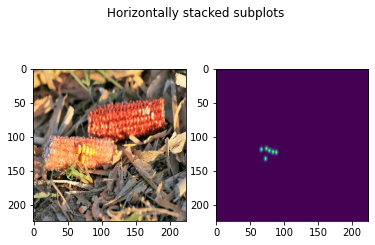

In [11]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].numpy().transpose(1, 2, 0)
label = train_labels[0].numpy().transpose(1, 2, 0)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(img)
ax2.imshow(label)
plt.show()

# Network architecture

In [12]:
class Map_CNN(nn.Module):
    def __init__(self, Pre_Trained_Encoder):
        super().__init__()
        
        self.encoder     = Pre_Trained_Encoder
         ### Encoder
        self.decoder = nn.Sequential(  
                       nn.Conv2d(in_channels  = 512,       # First convolutional layer
                                  out_channels = 256,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),                    #OUT  [nf X 14 X 14]
                        nn.Conv2d(in_channels  = 256,       
                                  out_channels = 128,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True), 
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 128,       
                                  out_channels = 64,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
                        nn.Conv2d(in_channels  = 64,       
                                  out_channels = 1,
                                  kernel_size  = 3,
                                  padding = 1,
                                  stride = 1),
                        nn.ReLU(True),
                        nn.Upsample(scale_factor=(2,2), mode='bilinear'),
            )
        
    def forward(self, x,mode):
        if (mode == "Train"):
            self.encoder.train()
            self.decoder.train()
        elif (mode == "Test"):
            self.encoder.eval()
            self.decoder.eval()
        y = self.encoder(x)
        y = self.decoder(y)
        return y
    
    
    ### Training function
    def train_epoch(self,device,dataloader, loss_fn, optimizer, verbose = True):
        """
        This function train the network for one epoch
        """
        # Train
        train_loss = []
        for data_batched, label_batched in dataloader:
            # Move data to device
            data_batched = data_batched.to(device)
            label_batched = label_batched.to(device)
            # process
            processed = self.forward(data_batched,"Train")
            # Compute loss
            loss = loss_fn(processed, label_batched)
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            #Updata weights
            optimizer.step()
            #Save trai loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        #Save the average train loss
        train_loss = np.mean(train_loss)
        if verbose: print(f"AVERAGE TRAIN LOSS: {train_loss}")

        return train_loss

    ### Testing function
    def test_epoch(self,device, dataloader, loss_fn, verbose= True):
        """
        This function test the network performance for one epoch of training
        """
        test_loss = []
        # Discable gradient tracking
        with torch.no_grad():
            for data_batched, label_batched in dataloader:
                # Move data to device
                data_batched = data_batched.to(device)
                label_batched = label_batched.to(device)
                # process
                processed = self.forward(data_batched,"Test")
                # Compute loss
                loss = loss_fn(processed, label_batched)
                 #Save test loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                test_loss.append(loss_batch)
            #Save the average train loss
            test_loss = np.mean(test_loss)
            if verbose: print(f"AVERAGE VALIDATION LOSS: {test_loss}")

        return test_loss
    
        
        
    def training_cycle(self, device, training_data, test_data, loss_fn, optim, num_epochs,
                       keep_model=False, verbose= True):
        """
        This function train the network for a desired number of epochs it also test the network 
        reconstruction performance and make plots comparing the input image and the reconstructed one every 5 epochs.
        """
        #I keep track of losses for plots
        train_loss = []
        test_loss  = []
        i = 0
        for epoch in tqdm(range(num_epochs)):
            if verbose: print('EPOCH %d/%d' % (epoch + 1, num_epochs))
            ### Training (use the training function)
            tr_l = self.train_epoch(
                device=device, 
                dataloader=training_data, 
                loss_fn=loss_fn, 
                optimizer=optim,
                verbose = verbose)
            train_loss.append(tr_l)
            ### Validation  (use the testing function)
            t_l = self.test_epoch(
                device=device, 
                dataloader=test_data, 
                loss_fn=loss_fn,
                verbose = verbose)
            test_loss.append(t_l)

        return train_loss, test_loss

In [13]:
VGG16 = torchvision.models.vgg16(pretrained = False)

In [14]:
VGG16.load_state_dict(torch.load('C:/Users/hilar/.cache/torch/hub/checkpoints/vgg16-397923af.pth'))

<All keys matched successfully>

In [15]:
enc = VGG16.features[0:20]

In [16]:
model = Map_CNN(enc)

In [17]:
### Disable the weight update for the trained encoder
for param_name, param in model.encoder.named_parameters():
    param.requires_grad = False

### Allow weight update (training) of the last layers (linear layers)
for param in model.decoder.parameters():
    param.requires_grad = True

### Check which weights and biases will be updated
for param_name, param in model.named_parameters():
    print(param_name,param.requires_grad)

encoder.0.weight False
encoder.0.bias False
encoder.2.weight False
encoder.2.bias False
encoder.5.weight False
encoder.5.bias False
encoder.7.weight False
encoder.7.bias False
encoder.10.weight False
encoder.10.bias False
encoder.12.weight False
encoder.12.bias False
encoder.14.weight False
encoder.14.bias False
encoder.17.weight False
encoder.17.bias False
encoder.19.weight False
encoder.19.bias False
decoder.0.weight True
decoder.0.bias True
decoder.2.weight True
decoder.2.bias True
decoder.5.weight True
decoder.5.bias True
decoder.8.weight True
decoder.8.bias True


In [20]:
max_epochs        = 25
learning_rate     = 1e-3

In [21]:
### Define the loss function for reconstruction
loss_fn = nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

#Send model to device
model.to(device)

Selected device: cpu


Map_CNN(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [22]:
train_loss, test_loss = model.training_cycle(device,
                                train_dataloader,
                                validation_dataloader,
                                loss_fn,
                                optimizer,
                                max_epochs,
                                keep_model=False,
                                verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

EPOCH 1/25
AVERAGE TRAIN LOSS: 72.95521545410156


  4%|▍         | 1/25 [01:07<26:49, 67.06s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 2/25
AVERAGE TRAIN LOSS: 5.184966087341309


  8%|▊         | 2/25 [02:24<27:58, 72.96s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 3/25
AVERAGE TRAIN LOSS: 5.321773529052734


 12%|█▏        | 3/25 [03:50<29:02, 79.22s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 4/25
AVERAGE TRAIN LOSS: 5.834151268005371


 16%|█▌        | 4/25 [05:16<28:38, 81.86s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 5/25
AVERAGE TRAIN LOSS: 5.699126720428467


 20%|██        | 5/25 [06:44<28:00, 84.03s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 6/25
AVERAGE TRAIN LOSS: 6.299149513244629


 24%|██▍       | 6/25 [08:10<26:51, 84.80s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 7/25
AVERAGE TRAIN LOSS: 5.617000579833984


 28%|██▊       | 7/25 [09:36<25:32, 85.15s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 8/25
AVERAGE TRAIN LOSS: 4.660436630249023


 32%|███▏      | 8/25 [11:02<24:10, 85.34s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 9/25
AVERAGE TRAIN LOSS: 4.658576965332031


 36%|███▌      | 9/25 [12:27<22:43, 85.21s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 10/25
AVERAGE TRAIN LOSS: 4.658878803253174


 40%|████      | 10/25 [13:53<21:24, 85.61s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 11/25
AVERAGE TRAIN LOSS: 6.583366394042969


 44%|████▍     | 11/25 [15:19<19:57, 85.53s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 12/25
AVERAGE TRAIN LOSS: 6.4756760597229


 48%|████▊     | 12/25 [16:45<18:34, 85.70s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 13/25
AVERAGE TRAIN LOSS: 5.5947699546813965


 52%|█████▏    | 13/25 [18:10<17:07, 85.67s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 14/25
AVERAGE TRAIN LOSS: 5.319307804107666


 56%|█████▌    | 14/25 [19:36<15:40, 85.53s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 15/25
AVERAGE TRAIN LOSS: 5.337582111358643


 60%|██████    | 15/25 [21:01<14:14, 85.48s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 16/25
AVERAGE TRAIN LOSS: 5.1896772384643555


 64%|██████▍   | 16/25 [22:26<12:48, 85.38s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 17/25
AVERAGE TRAIN LOSS: 4.723563194274902


 68%|██████▊   | 17/25 [23:51<11:20, 85.12s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 18/25
AVERAGE TRAIN LOSS: 6.940464973449707


 72%|███████▏  | 18/25 [25:19<10:01, 85.98s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 19/25
AVERAGE TRAIN LOSS: 4.859650135040283


 76%|███████▌  | 19/25 [26:44<08:34, 85.80s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 20/25
AVERAGE TRAIN LOSS: 4.6643781661987305


 80%|████████  | 20/25 [28:09<07:07, 85.48s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 21/25
AVERAGE TRAIN LOSS: 6.2964630126953125


 84%|████████▍ | 21/25 [29:34<05:41, 85.31s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 22/25
AVERAGE TRAIN LOSS: 4.658475399017334


 88%|████████▊ | 22/25 [30:59<04:15, 85.27s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 23/25
AVERAGE TRAIN LOSS: 4.660719394683838


 92%|█████████▏| 23/25 [32:24<02:50, 85.35s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 24/25
AVERAGE TRAIN LOSS: 6.080771446228027


 96%|█████████▌| 24/25 [33:50<01:25, 85.50s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572
EPOCH 25/25
AVERAGE TRAIN LOSS: 5.324382781982422


100%|██████████| 25/25 [35:17<00:00, 84.69s/it]

AVERAGE VALIDATION LOSS: 7.052561283111572


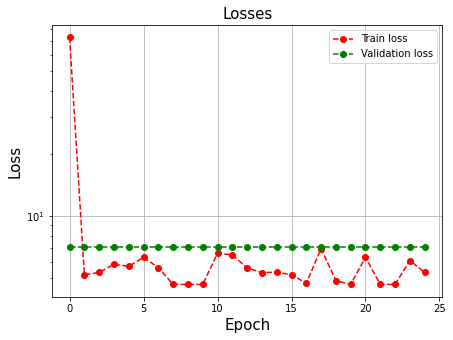

In [23]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

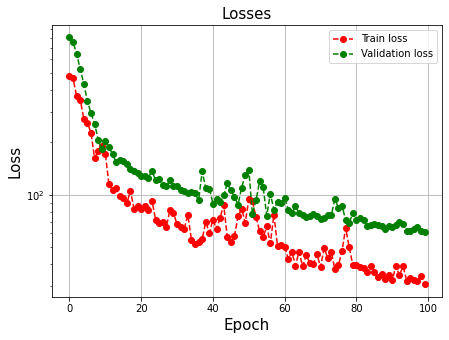

In [20]:
# Plot losses by epoch
plt.figure(figsize=(7,5))
plt.semilogy(train_loss, linestyle='--', marker='o', color='r', label='Train loss')
plt.semilogy(test_loss, linestyle='--', marker='o', color='g', label='Validation loss')
plt.xlabel('Epoch',fontsize=15)
plt.ylabel('Loss',fontsize=15)
#plt.ylim(0,80)
plt.title("Losses",fontsize=15)
plt.grid()
plt.legend()
#plt.savefig('./imgs/classification/losses.svg', format='svg')
plt.show()

In [25]:
#prediccion = []

with torch.no_grad():
    for data in test_dataloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs = inputs.to(device)
        # forward + backward + optimize
        outputs = model(inputs, "Test")
        outputs = outputs.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        #prediccion.append([outputs[0][0],labels[0]])
#prediccion = np.array(prediccion)

In [26]:
idx = 2
input_image = inputs.detach().cpu().numpy()[idx]
predicted_map = outputs[idx]
original_map = labels[idx]

In [27]:
print("Predicted map:")
print("Shape",predicted_map.shape)
print("Min", predicted_map.min())
print("Maxp",predicted_map.max())
print("")
print("Original map:")
print("Shape",original_map.shape)
print("Min",original_map.min())
print("Maxp",original_map.max())


Predicted map:
Shape (1, 224, 224)
Min 0.0
Maxp 0.0

Original map:
Shape (1, 224, 224)
Min 0.0
Maxp 2.4520712


Basically it is predicting all as 0 and thats why it is achieving such a low loss, so i will enlarge it to get better results.

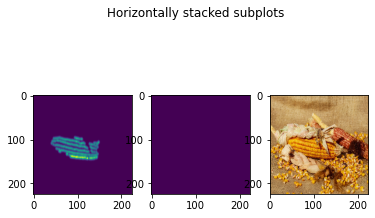

In [28]:
# Display image and label.
#img = prediccion[0][0]
#label = prediccion[0][1].transpose(1, 2, 0)

fig, (ax1, ax2,ax3) = plt.subplots(1, 3)
fig.suptitle('Horizontally stacked subplots')
ax1.imshow(original_map[0])
ax2.imshow(predicted_map[0])
ax3.imshow(input_image.transpose(1, 2, 0))
plt.show()

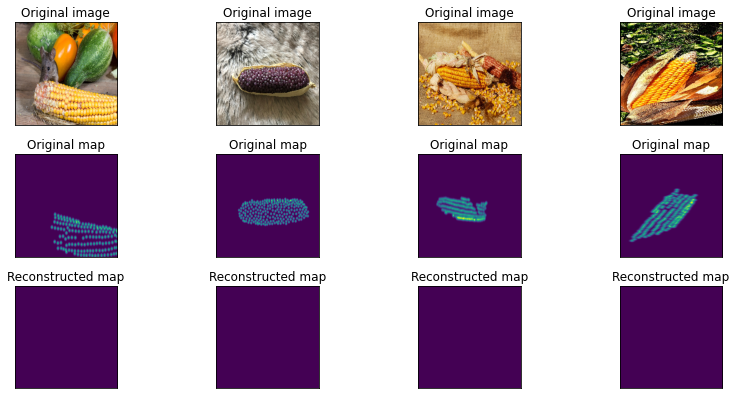

In [29]:
elements = [0,1,2,3]

fig, axs = plt.subplots(3, 4, figsize=(12,6))
fig.suptitle("",fontsize=15)
fig.subplots_adjust(top=0.88)
axs = axs.ravel()
for i in range(4):
    idx = elements[i]
    predicted_map = outputs[idx][0]
    original_map = labels[idx][0]
    input_image = input_image = inputs.detach().cpu().numpy()[idx]
    # Plot the reconstructed image
    axs[i].imshow(input_image.transpose(1, 2, 0))
    axs[i].set_title("Original image")
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i+4].imshow(original_map)
    axs[i+4].set_title("Original map")
    axs[i+4].set_xticks([])
    axs[i+4].set_yticks([])
    axs[i+8].imshow(predicted_map)
    axs[i+8].set_title('Reconstructed map')
    axs[i+8].set_xticks([])
    axs[i+8].set_yticks([])
plt.tight_layout()
fig.subplots_adjust(top=0.88)

In [31]:
mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\hilar/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:09<00:00, 1.48MB/s]


In [34]:
print(mobilenet.features)

Sequential(
  (0): ConvNormActivation(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU6(inplace=True)
  )
  (1): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (2): InvertedResidual(
    (conv): Sequential(
      (0): ConvNormActivation(
        (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Re

In [79]:
#####################################################################
#####################################################################
# keep this to upsample the images and get the right count
# for this to work we need the original image size
# which is not simple to pass but ill need it for the final count only

label = train_labels[0]
print(label.size())
# I need to add a dummy axis simulating the minibatch dimension
label = label[None, :]
print(label.size())

# Upsample to the right dimension
m = nn.Upsample(size=(1280,1920),mode='bilinear')
label_2 = m(label)
print(label_2.size())

torch.Size([1, 224, 224])
torch.Size([1, 1, 224, 224])
torch.Size([1, 1, 1280, 1920])


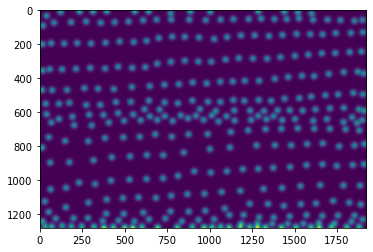

In [80]:
plt.imshow(label_2[0].numpy().transpose(1, 2, 0))

In [81]:
np.sum(label_2[0].numpy())

340.00116